# Tölulegt verkefni Stærðfræðigreining IV

Hér er verkefnið
$$
\begin{align}
    \begin{cases}
        Lu = -\nabla \cdot (\nabla u) + \frac{2H}{\delta K}u=0 & \text{á } D\\
        -Fu + \frac{\partial u}{\partial n} = 0 & \text{á } \partial D_K \\
        \frac{\partial u}{\partial n} = E & \text{á } \partial D_H
    \end{cases}
\end{align}
$$
leyst tölulega. Nákvæmur útleiðslur fyrir nálgunarjöfnum má nálgast í skýrslunni.

In [2]:
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as spla

In [3]:
def change(j: int,k: int,n: int):
    '''
    Fall sem að breytir tvívíðri stikun (j,k) í einvíða i

    Inntak:
        j: x-vísir tvívíðu breytu
        k: y-vísir tvívíðu breytu
        n: fjöldi punkta í x-stefnu

    Úttak:
        i: einvíða hnitið
    '''
    i = j+k*n
    return i

In [4]:
def varmadreifing(Lx: float, Ly: float, N: int, M: int, L: float, delta: float, P: float, K: float, H: float, ub: float, fgalla=-1, gallabil=None ):
    '''
    Fall varmadreifing sem að nálgar lausnina á varmaleiðniverkefninu (1) lýst hér að ofan

    Inntak:
        Lx: Lárétt lengd plötu (cm)
        Ly: Lóðrétt lengd plötu (cm)
        N: Fjöldi hlutbila á x-ási
        M: Fjöldi hlutbila á y-ási
        L: Lengd svæðis sem inn berst um varmaafl (cm)
        delta: Þykkt plötu (cm)
        P: Varmaafl inn í plötu (W)
        K: Varmaleiðnistuðull plötu (W/cm C)
        H: Útþennslustuðull burðarvarma (W/cm C)
        ub: Rétt umhverfishitastig
        fgalla: fjöldi punkta með fast hitastig
        gallabil: bil [a,b] þar sem a og b eru rauntölur

    Úttak:
        X_net: stak (j,k) jafngildir x_j
        Y_net: stak (j,k) jafngildir y_k
        w: stak (j,k) jafngildir hitastigi í punkti (j,k) í netinu
    '''

    # Lengd hitasvæðis verður að vera minni en lengd y
    assert L<= Ly


    # Finnum alla punkta x_i og y_i
    xi = np.linspace(0,Lx,N+1)
    yi = np.linspace(0,Ly,M+1)

    # Reiknum stuðla h_x og h_y
    hx = Lx / N
    hy = Ly / M

    # Táknmál í edBook gefur
    q = (2*H) / (delta*K)
    F = H / K
    E = P / (L*delta*K)

    # Setjum upp fylki A og vigur b
    n = N+1
    m = M+1

    A = sp.lil_matrix((n*m,n*m))
    b = np.zeros(n*m)

    # Metum gildin í innri punktum netsins
    for j in range(1,n-1):
        for k in range(1,m-1):
            i = change(j,k,n)
            A[i,i]=2*(hx**(-2))+2*(hy**(-2))+q
            A[i,i-1] = -(hx**(-2))
            A[i,i+1] = -(hx**(-2))
            A[i,i-n] = -(hy**(-2))
            A[i,i+n] = -(hy**(-2))

    # Metum gildin á vinstri jaðri
    for k in range(1,m-1):
      i = change(0,k,n)
      # Athugum hvort við séum á hitunarjaðri
      # punktur (x_i,y_i) hefur hnit (0,k*hy)
      if (Ly/2 - L/2) <= k*hy and k*hy <= (Ly/2 + L/2):
        # Við erum á hitunarjaðri
        alpha = 0
        gamma = E
      else:
        # Við erum á kælingarjaðri
        alpha = -F
        gamma = 0
      # Þá má reikna gildin
      A[i,i] = 2*(hx**(-2))+2*(hy**(-2))+q+2*(hx**(-1))*alpha
      A[i,i+1] = -2*(hx**(-2))
      A[i,i-n] = -(hy**(-2))
      A[i,i+n] = -(hy**(-2))
      b[i] = 2*(hx**(-1))*gamma

    #Metum gildin í botn jaðri
    for j in range(1,n-1):
      i = change(j,0,n)
      A[i,i] = -2*F*(hy**(-1))+2*(hy**(-2))+2*(hx**(-2))+q
      A[i,i+n] = -2*(hy**(-2))
      A[i,i-1] = -(hx**(-2))
      A[i,i+1] = -(hx**(-2))
      b[i] = 0

    #Metum gildin í hægri jaðri
    for k in range(1,m-1):
      i = change(n-1, k, n)
      A[i,i] = -2*F*(hx**(-1))+2*(hx**(-2))+2*(hy**(-2))+q
      A[i,i-1] = -2*(hx**(-2))
      A[i,i+n] = -(hy**(-2))
      A[i,i-n] = -(hy**(-2))
      b[i] = 0

    # Metum gildin í efri jaðri
    for j in range(1,n-1):
      i = change(j,m-1,n)
      A[i,i] = -2*F*(hy**(-1))+2*(hy**(-2))+2*(hx**(-2))+q
      A[i,i-n] = -2*(hy**(-2))
      A[i,i-1] = -(hx**(-2))
      A[i,i+1] = -(hx**(-2))
      b[i]=0

    #Metum hornpunktana
    binary = int(L < Ly) # breyta sem er 1 ef yrðing sönn og 0 annars

    #Vinstra horn niðri
    i = change(0,0,n)
    A[i,i] = 2*(hx**(-2))+2*(hy**(-2))+q-2*F*((hx**(-1))*binary+(hy**(-1)))
    A[i,i+1] = -2*(hx**(-2))
    A[i,i+n] = -2*(hy**(-2))
    b[i] = 2*(hx**(-1))*E*(1-binary)

    #Vinstra horn uppi
    i = change(0,m-1,n)
    A[i,i] = 2*(hx**(-2))+2*(hy**(-2))+q-2*F*((hx**(-1))*binary+(hy**(-1)))
    A[i,i+1] = -2*(hx**(-2))
    A[i,i-n] = -2*(hy**(-2))
    b[i] = 2*(hx**(-1))*E*(1-binary)

    #hægra horn uppi
    i = change(n-1,m-1,n)
    A[i,i] = 2*(hx**(-2))+2*(hy**(-2))+q-2*F*((hx**(-1))+(hy**(-1)))
    A[i,i-1] = -2*(hx**(-2))
    A[i,i-n] = -2*(hy**(-2))
    b[i] = 0

    #hægra horn niðri
    i = change(n-1,0,n)
    A[i,i] = 2*(hx**(-2))+2*(hy**(-2))+q-2*F*((hx**(-1))+(hy**(-1)))
    A[i,i-1] = -2*(hx**(-2))
    A[i,i+n] = -2*(hy**(-2))
    b[i] = 0

    # Verkefni 2
    # förum bara í þennan hluta ef gildi eru gefin
    if fgalla > 0 and gallabil is not None:
      # velja slembna punkta í neti
      indices = np.random.choice(n * m, size=fgalla, replace=False)
      for index in indices:
        # fyrir hvern punkt velja slembið hitastig
        temp = np.random.uniform(gallabil[0], gallabil[1])
        # festa hitastig
        A[index,:] = 0
        A[index,index] = 1
        b[index] = temp


    # Yfirfæra A á form sem virkar í linalg.solve
    A_csr = A.tocsr()


    #Leysa!
    c = spla.spsolve(A_csr, b)

    # Bæta við umhverfishitastigi
    c += ub


    # Reshape-a í nxm fylki w
    w = c.reshape((n, m), order='F')

    # Skilgreina X_net og Y_net
    Xnet, Ynet = np.meshgrid(xi, yi, indexing='ij')

    return Xnet, Ynet, w

## Prófanir

Hér verða framkvæmdir prófanir í samræmi við verkefna lýsingu.

### **Liður 1.**
Byrjið með kæliplötu af stærðinni $2 \times 2$ cm, með 1 mm þykkt. Gerið ráð fyrir
að afl $P = 5$W sé leitt inn um vinstri brún um svæði af lengd $L = 2$ cm.

Finnið nálgunarlausn á verkefni með $N = M = 10$ skrefum í $x$ og $y$ stefnur.

Teiknið annars vegar upp þrívítt graf og hins vegar upp jafnhæðarlínur sem sýna
nálgunarlausnina sem fall af $x$ og $y$. Munið að merkja ása grafsins og útskýra
forsendur í texta (t.d. gildi á stikum). Finnið hæsta gildi á hitastigi í kæliplötu.

In [5]:
# Við keyrum fallið fyrir gildi gefin í 1 og fáum nálgunarlausn w
Xnet, Ynet, w =varmadreifing(2,2,10,10,2,0.1,5,1.68,0.005,20)

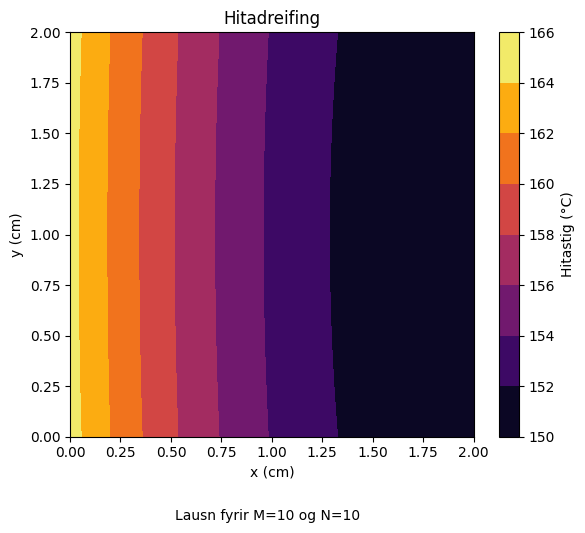

In [6]:
import matplotlib.pyplot as plt

# Skilgreinum og keyrum fall sem teiknar jafnhæðarlínur nálguninnar
def jafnhaedar(Xnet, Ynet, w, label):
  '''
  Fall sem að teiknar jafnhæðarlínur
  Inntak:
    Xnet: x-hnit netsins
    Ynet: y-hnit netsins
    w: hitastigsfylkið
    label: texti undir mynd
  '''
  plt.figure(figsize=(6,5))
  contour = plt.contourf(Xnet, Ynet, w, cmap='inferno')
  plt.colorbar(contour, label='Hitastig (°C)')
  plt.xlabel('x (cm)')
  plt.ylabel('y (cm)')
  plt.title('Hitadreifing')
  plt.tight_layout()
  plt.figtext(0.3, -0.05,label)
  plt.show()

jafnhaedar(Xnet,Ynet,w,'Lausn fyrir M=10 og N=10')

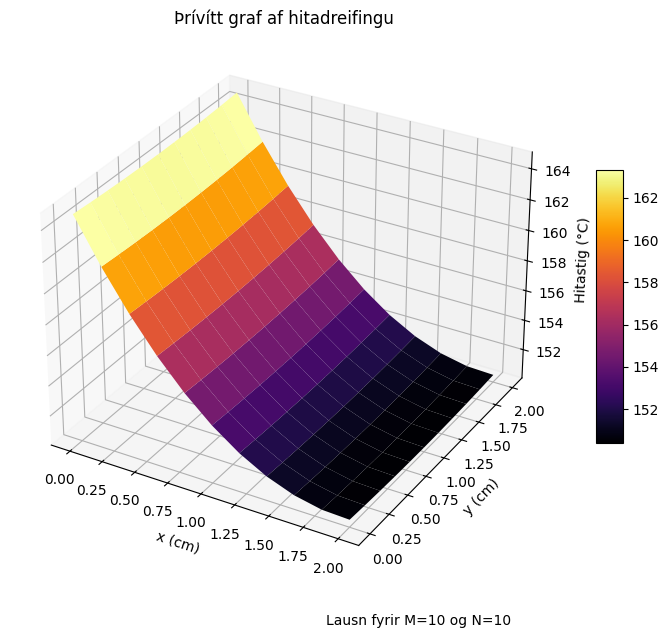

In [7]:
from mpl_toolkits.mplot3d import Axes3D

# Skilgreinum og keyrum fall sem að teiknar nálgunarlausnina í þrívídd
def threedee(Xnet, Ynet, w, label):
  '''
  Fall sem að teiknar graf hitastigsins í þrívídd
  Inntak:
    Xnet: x-hnit netsins
    Ynet: y-hnit netsins
    w: hitastigsfylkið
    label: texti undir mynd
  '''
  # skilgreina graf
  fig = plt.figure(figsize=(8, 6))
  ax = fig.add_subplot(111, projection='3d')
  surf = ax.plot_surface(Xnet, Ynet, w, cmap='inferno', edgecolor='none')

  # Setja merkingar
  ax.set_xlabel('x (cm)')
  ax.set_ylabel('y (cm)')
  ax.set_zlabel('Hitastig (°C)')
  ax.set_title('Þrívítt graf af hitadreifingu')
  plt.figtext(0.5, -0.05,label)

  # Litastika
  fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)

  plt.tight_layout()
  plt.show()

threedee(Xnet,Ynet,w,'Lausn fyrir M=10 og N=10')


In [8]:
# Skilgreinum og keyrum fall til þess að finna hæsta gildi hitastigs í plötunni
def haesta_gildi(Xnet, Ynet, w):
  '''
  Finnur og prentar út hvað hæsta hitastigið er og hvar það er.
  Inntak:
    Xnet: x-hnit netsins
    Ynet: y-hnit netsins
    w: hitastigsfylkið
  '''
  flat_index = np.argmax(w) # finnur index á hæsta gildi
  j, k = np.unravel_index(flat_index, w.shape) # fáum tvívíðan index
  max = np.max(w) # fáum hæsta gildi
  print(f'Hæsta hitastig er {round(max,2)}˚ en það er í punkti (x,y)=({Xnet[j,k]},{Ynet[j,k]})')

haesta_gildi(Xnet,Ynet, w)

Hæsta hitastig er 164.78˚ en það er í punkti (x,y)=(0.0,2.0)


###**Liður 2.**
 Stækkið kæliplötuna í $4 \times 4$ cm en haldið öðru óbreyttu. Teiknið með sama
hætti og áður og finnið hámarkshitastigið.

Prófið að nota hærri gildi á N og M
og lýsið því hvernig hámarkshitastigið breytist.

Stefnir niðurstaðan á eitthvað
markgildi þegar N og M stækka? Setjið hámarkshitastigið upp á graf sem fall
af N = M fyrir nokkur vaxandi gildi á N og M .

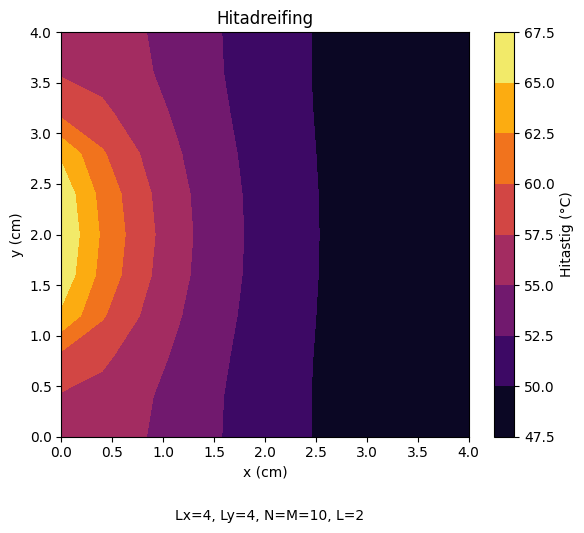

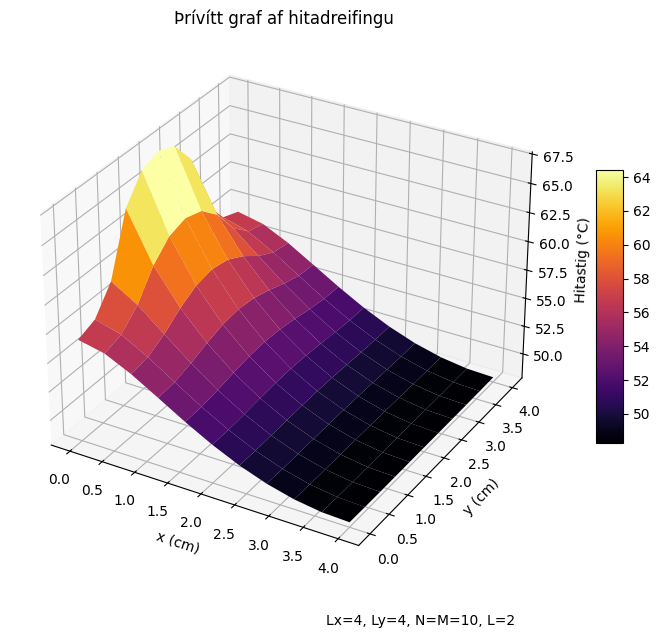

In [9]:
# Stækkum plötu í 4cm x 4cm og teiknum aftur lausnir
Xnet, Ynet, w =varmadreifing(4,4,10,10,2,0.1,5,1.68,0.005,20)
jafnhaedar(Xnet,Ynet,w,'Lx=4, Ly=4, N=M=10, L=2')
threedee(Xnet,Ynet,w,'Lx=4, Ly=4, N=M=10, L=2')

In [10]:
# Finnum hæsta hitastig
haesta_gildi(Xnet,Ynet,w)

Hæsta hitastig er 67.27˚ en það er í punkti (x,y)=(0.0,2.0)


In [11]:
# Prófum að auka fjölda bila í 20 og sjá hvernig hæsta hitastig breytist
Xnet, Ynet, w =varmadreifing(4,4,20,20,2,0.1,5,1.68,0.005,20)
haesta_gildi(Xnet,Ynet,w)

Hæsta hitastig er 71.16˚ en það er í punkti (x,y)=(0.0,2.0)


Við sjáum að hitastigið hækkar. Prófum nú að skoða hæsta hitastigið sem fall af M=N

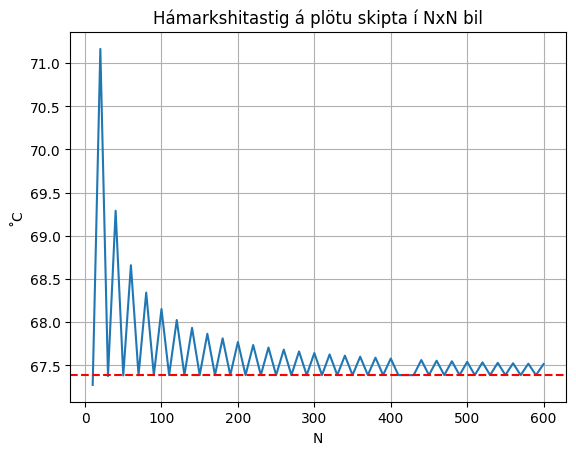

In [12]:
no_measures = 60 #fjöldi mælinga
max_temp2 = np.zeros(no_measures)
N = np.linspace(10,no_measures*10,no_measures) #gildi á N=M

# Finna hæsta hitastig fyrir allar mælingar
for i in range(no_measures):
  Xnet, Ynet, w =varmadreifing(4,4,int(N[i]),int(N[i]),2,0.1,5,1.68,0.005,20)
  max_temp2[i] = np.max(w)

# Teikna niðurstöður
plt.plot(N,max_temp2)
plt.xlabel('N')
plt.ylabel('˚C')
plt.title('Hámarkshitastig á plötu skipta í NxN bil')
plt.grid(True)
plt.axhline(y=max_temp2[no_measures-2] , color='r', linestyle='--', label='Lágmark hámarkshitastig')
plt.show()

Þar sem rauða línan er í hæð næst síðustu mælingar og merkir láfelluna sem við teljum hæsta hitastigið stefna á.

###**Liður 3**

Finnið hámarksafl sem hægt er að dreifa með $4 \times 4$ cm kæliplötu þannig að
hámarkshitastigið sé undir 80 ˚C. Veljið N og M miðað við niðurstöður í lið 3
og útskýrið ástæðuna fyrir valinu.

Við veljum $M=N=420$ þar sem að þá erum við komin ansi nálægt gildinu sem hitastigið virðist stefna á auk þess sem að skiptingin er ekki orðin alltof stór svo útreikningar verði hægir.

Til þess að finna hæsta aflið framkvæmum við helmingunarleit, þ.e.a.s. reiknum gerum ráð fyrir að aflið sé á bilinu [a,b], reiknum mesta hitastigið fyrir aflið $m=(b+a)/2$, ef hitastigið er meira en 80 skoðum við bilið $[a,m]$ en annars $[m,b]$. Við förum síðan aftur í fyrsta skref nema fyrir þetta bil og endurtökum þangað til hæsta hitastigið er innan einhverra marka frá 80˚.

In [57]:
# Framkvæmum helmingunarleit til þess að finna hæsta aflið þannig að aflið sé undir 80 C

def find_max_P(K, H, lower=5.0, upper=7.0, tol=1e-3):
    '''
    Fall sem finnur hæsta gildið á afli þannig að það sé undir 80˚.
    Inntak:
      K: Varmaleiðnistuðull
      H: Varmaflutningstuðull
      lower: neðri mörk afls
      upper: efri mörk afls
      tol: skekkja frá 80

    Úttak:
      mesta afl P
    '''
    while upper - lower > tol:
        # finna miðunkt
        mid = (lower + upper) / 2
        Xnet, Ynet, w = varmadreifing(4, 4, 420, 420, 2, 0.1, mid, K, H, 20)
        # hæsta hitastig
        max_temp = np.max(w)

        # velja nýtt bil
        if max_temp < 80:
            lower = mid
        else:
            upper = mid

    return lower


max_safe_P = find_max_P(1.68, 0.005)
print(f"Mesta afl P þannig að hæsta hitastig sé < 80°C: {max_safe_P:.3f}")


Mesta afl P þannig að hæsta hitastig sé < 80°C: 6.330


Skoðum hvernig niðurstaðan lítur út með því gildi á P

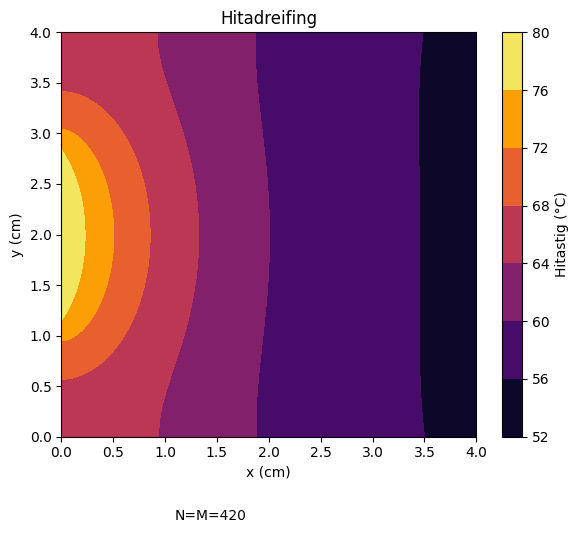

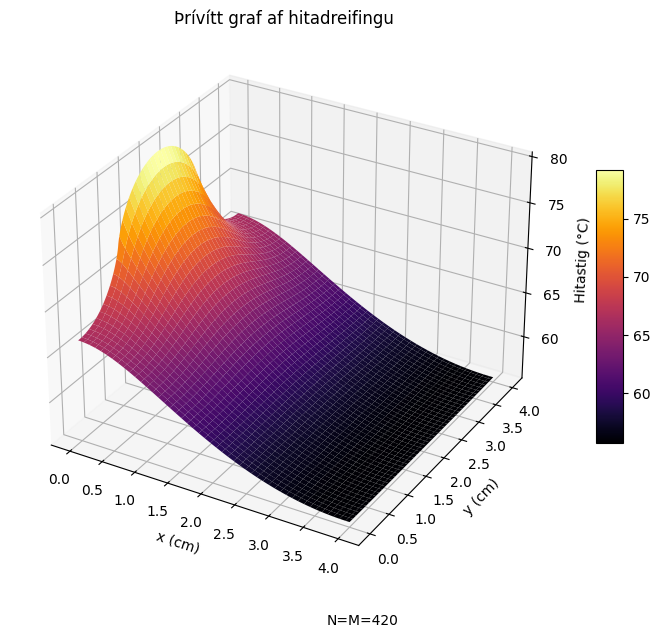

In [54]:
Xnet, Ynet, w =varmadreifing(4,4,420,420,2,0.1,max_safe_P,1.68,0.005,20)
jafnhaedar(Xnet,Ynet,w,'N=M=420')
threedee(Xnet,Ynet,w,'N=M=420')

Þar sem hæsta hitastigið verður

In [51]:
haesta_gildi(Xnet,Ynet,w)

Hæsta hitastig er 79.99˚ en það er í punkti (x,y)=(0.0,1.9904761904761907)


###**Liður 4**
Skiptið út áli fyrir kopar með varmaleiðni
$$
K=3.85 \;W/(cm˚C)
$$
endurtökum skref 3.

In [56]:
# Endurtökum skref 3
K_kopar = 3.85 # varmaleiðni kopars
max_safe_P = find_max_P(K_kopar, 0.005, upper=10) # finnum mesta aflið
print(f"Mesta afl P þannig að hæsta hitastig sé < 80°C: {max_safe_P:.3f}")
Xnet, Ynet, w = varmadreifing(4,4,420,420,2,0.1,max_safe_P,K_kopar,0.005,20)
haesta_gildi(Xnet,Ynet,w)

Mesta afl P þannig að hæsta hitastig sé < 80°C: 7.644
Hæsta hitastig er 80.0˚ en það er í punkti (x,y)=(0.0,1.9904761904761907)


### **Liður 5**

Endurtakið skref 3 og 4 fyrir vatnskælda plötu. Gert er ráð fyrir að útþenslustuðull burðarvarma vatns sé
$$
H = 0.1 \;W/(cm˚C)
$$
og að umhverfishitastigi vatnsins sé haldið í 20˚C.


Við byrjum á því að finna mesta aflið fyrir plötuna úr áli

In [61]:
K_al = 1.68 # varmaleiðni áls
H_vatn = 0.1
max_safe_P = find_max_P(K_al, H_vatn, lower = 0, upper=100) # finnum mesta aflið
print(f"Mesta afl P þannig að hæsta hitastig sé < 80°C: {max_safe_P:.3f}")
Xnet, Ynet, w = varmadreifing(4,4,420,420,2,0.1,max_safe_P,K_al,H_vatn,20)
haesta_gildi(Xnet,Ynet,w)

Mesta afl P þannig að hæsta hitastig sé < 80°C: 26.453
Hæsta hitastig er 80.0˚ en það er í punkti (x,y)=(0.0,1.9904761904761907)


Við skulum skoða hvernig platan lítur út þá

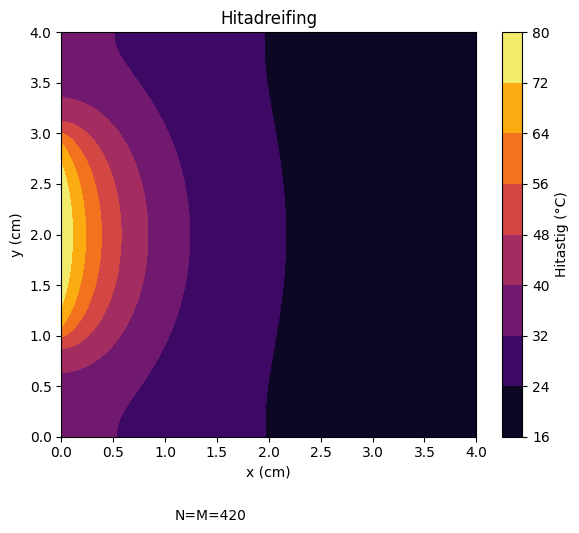

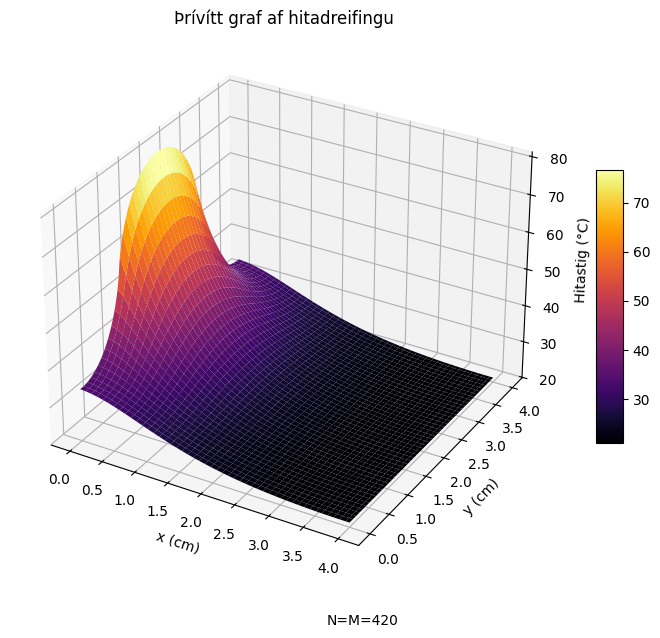

In [62]:
jafnhaedar(Xnet,Ynet,w,'N=M=420')
threedee(Xnet,Ynet,w,'N=M=420')

Framkvæmum söömu tilraun nema núna fyrir kopar.

In [63]:
K_kopar = 3.85 # varmaleiðni áls
H_vatn = 0.1
max_safe_P = find_max_P(K_kopar, H_vatn, lower = 0, upper=100) # finnum mesta aflið
print(f"Mesta afl P þannig að hæsta hitastig sé < 80°C: {max_safe_P:.3f}")
Xnet, Ynet, w = varmadreifing(4,4,420,420,2,0.1,max_safe_P,K_kopar,H_vatn,20)
haesta_gildi(Xnet,Ynet,w)

Mesta afl P þannig að hæsta hitastig sé < 80°C: 44.327
Hæsta hitastig er 80.0˚ en það er í punkti (x,y)=(0.0,1.9904761904761907)


Við fáum þá gröf:

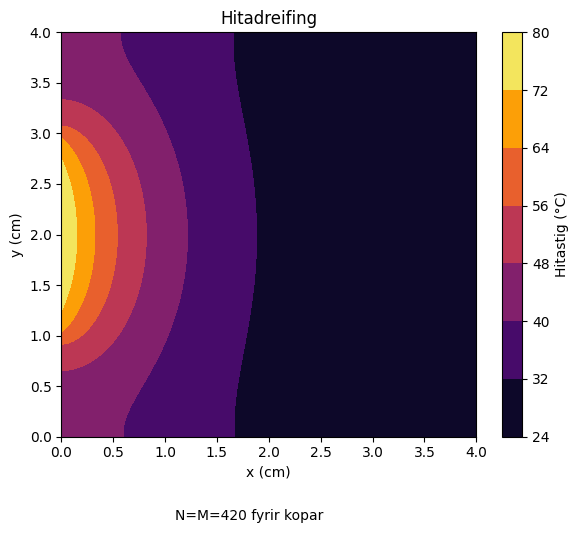

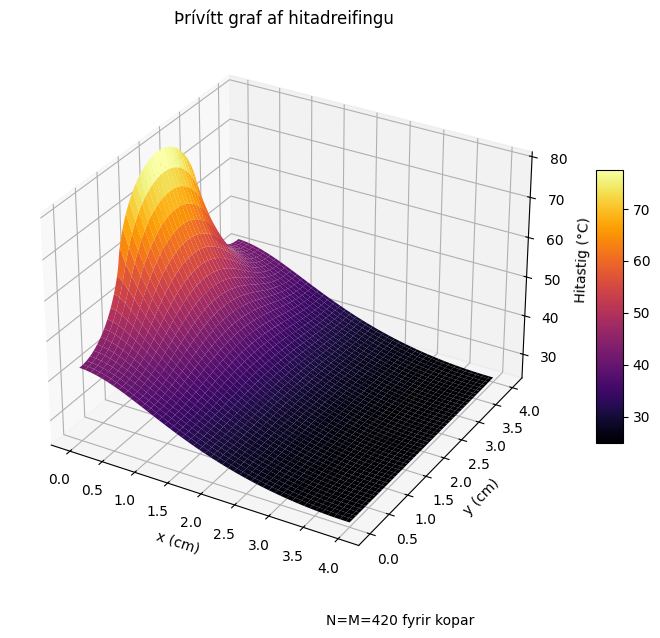

In [65]:
jafnhaedar(Xnet,Ynet,w,'N=M=420 fyrir kopar')
threedee(Xnet,Ynet,w,'N=M=420 fyrir kopar')

## **Verkefni 2**

Stillið alla stika á sömu gildi og í skrefi 1 í prófunum Verkefnis 1. Prófið að breyta N ,
M og L og fjölda gallapunkta og hitastigsbilinu sem hiti þeirra lendir á. Skilið þeirri
mynd sem ykkur finnst flottust. Niðurstaðan fer í samkeppnina Eddan 2025. Hér má
taka sér ákveðið listrænt frelsi!

Við veljum
- N = 40
- M = 400
- L = 1.1
- fgalla = 15
- gallabil = [20,40]
Þá fæst mynd

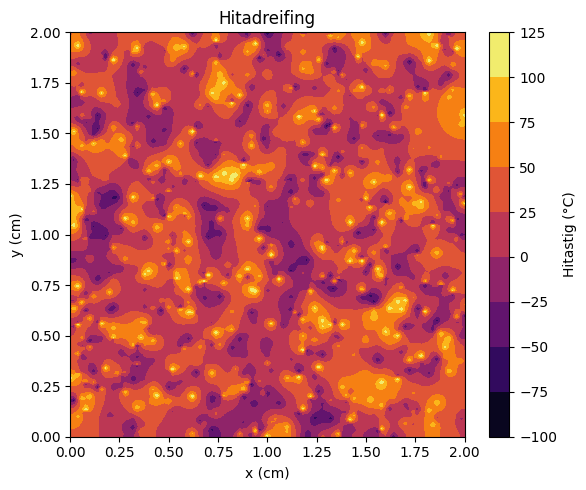

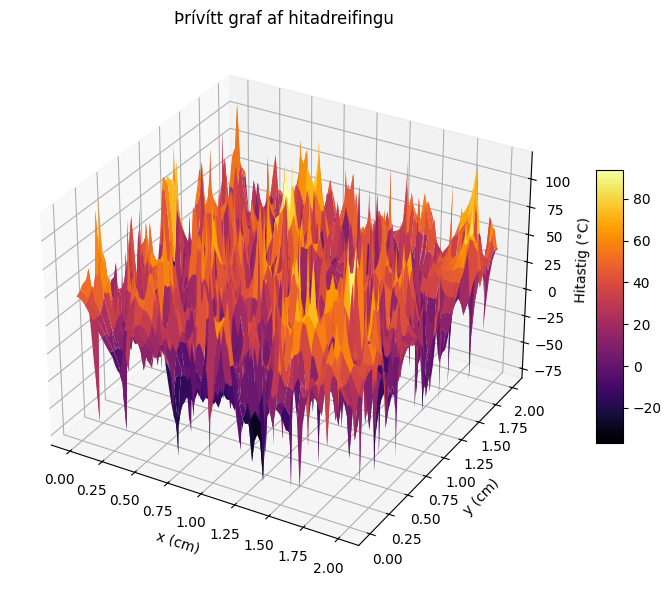

In [78]:
Xnet, Ynet, w =varmadreifing(2,2,100,400,1.1,0.1,5,1.68,0.005,20, 1000, [-100, 100])
jafnhaedar(Xnet,Ynet,w,'')
threedee(Xnet,Ynet,w,'')